# The Battle of Neighborhoods
## New restaurant location in New York city (Manhattan)
### Introduction/Business Problem
ABC Chinese chain restaurant is from western coast and currently looking for a new store in New York city. However, New York city is very diverse and is the financial capitals of the country. It has a total of 5 boroughs and 306 neighborhoods, which makes it hard to find a good location manually. Therefore, ABC company asked me to assist them to make data-driven decisions on the new locations that are most suitable for their new stores in Manhattan.   
### Data

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. Luckily, this dataset exists for free on the web. Here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

In [1]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


Import Libraries that needed

In [2]:
# Import libraries
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files
import pandas as pd

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from bs4 import BeautifulSoup

# Import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0           conda-forge
    geopy:          

Review the data and convert it to pandas dataframe

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [4]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [5]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [6]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(len(neighborhoods['Borough'].unique()),neighborhoods.shape[0]))

The dataframe has 5 boroughs and 306 neighborhoods.


Use geopy library to get the latitude and longitude values of Manhattan.

Create a map of Manhattan with neighborhoods superimposed on top.

Use the Foursquare API to explore the Manhattan

In [10]:
CLIENT_ID = 'TCS4JFCHOIMWMME2HSNDBUR13GGWNYTWMWHXQO2OIBIWBVLN' # your Foursquare ID
CLIENT_SECRET = 'ICLMQ1RDW2R1ZBJYJDJSL5QTBX4HF32XV2LD0STSMOMGIDXA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TCS4JFCHOIMWMME2HSNDBUR13GGWNYTWMWHXQO2OIBIWBVLN
CLIENT_SECRET:ICLMQ1RDW2R1ZBJYJDJSL5QTBX4HF32XV2LD0STSMOMGIDXA


In [11]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [12]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [13]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

### Exploratory data analysis

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Create a nearby venues function for all the neighborhoods in Manhattan

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
Manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )


Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [20]:
print(Manhattan_venues.shape)
Manhattan_venues.head(20)

(3030, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
5,Marble Hill,40.876551,-73.91066,Rite Aid,40.875467,-73.908906,Pharmacy
6,Marble Hill,40.876551,-73.91066,TCR The Club of Riverdale,40.878628,-73.914568,Tennis Stadium
7,Marble Hill,40.876551,-73.91066,Land & Sea Restaurant,40.877885,-73.905873,Seafood Restaurant
8,Marble Hill,40.876551,-73.91066,Starbucks,40.873755,-73.908613,Coffee Shop
9,Marble Hill,40.876551,-73.91066,Astral Fitness & Wellness Center,40.876705,-73.906372,Gym


Check how many venues were returned for each neighborhood

In [21]:
Manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,63,63,63,63,63,63
Carnegie Hill,84,84,84,84,84,84
Central Harlem,45,45,45,45,45,45
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,91,91,91,91,91,91
Clinton,100,100,100,100,100,100
East Harlem,42,42,42,42,42,42
East Village,100,100,100,100,100,100


Calculate how many unique venue categories there are

In [22]:
# Calculate how many unique categories there are.
print('There are {} unique venue categories.'.format(len(Manhattan_venues['Venue Category'].unique())))

There are 329 unique venue categories.


Analyze each of the Neighborhoods

In [23]:
# Analyze each of the Neighborhoods from the results

# one hot encoding
Manhattan_onehot = pd.get_dummies(Manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Manhattan_onehot['Neighborhood'] = Manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Manhattan_onehot.columns[-1]] + list(Manhattan_onehot.columns[:-1])
Manhattan_onehot = Manhattan_onehot[fixed_columns]

Manhattan_onehot

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group rows by neighborhood and take the mean of the frequency of occurrence of each category

In [24]:
manhattan_grouped = Manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.015873,0.047619,0.000,0.000000,0.000000
1,Carnegie Hill,0.000000,0.000000,0.00,0.000000,0.011905,0.000000,0.000000,0.000000,0.011905,...,0.00,0.023810,0.000000,0.000000,0.000000,0.011905,0.035714,0.000,0.000000,0.035714
2,Central Harlem,0.000000,0.000000,0.00,0.066667,0.044444,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000
3,Chelsea,0.000000,0.000000,0.00,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.000,0.010000,0.000000
4,Chinatown,0.000000,0.000000,0.00,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000
5,Civic Center,0.000000,0.000000,0.00,0.000000,0.043956,0.010989,0.000000,0.000000,0.000000,...,0.00,0.010989,0.000000,0.000000,0.000000,0.010989,0.010989,0.000,0.000000,0.032967
6,Clinton,0.000000,0.000000,0.00,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.010000,0.040000,0.000,0.000000,0.000000
7,East Harlem,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000
8,East Village,0.000000,0.000000,0.00,0.000000,0.010000,0.000000,0.000000,0.010000,0.010000,...,0.00,0.030000,0.000000,0.000000,0.000000,0.030000,0.010000,0.000,0.000000,0.000000
9,Financial District,0.000000,0.000000,0.00,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000,0.010000,0.010000


In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### The top 10 venue categories for each neighborhood  
This is a very useful results table that can provide us good information for all of the districts. We can know which area is good for restaturants

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Wine Shop,Boat or Ferry,Gym,Coffee Shop,Memorial Site,Shopping Mall,Gourmet Shop,Food Court
1,Carnegie Hill,Coffee Shop,Pizza Place,Yoga Studio,Bookstore,Japanese Restaurant,Grocery Store,Gym,Café,Wine Shop,Vietnamese Restaurant
2,Central Harlem,African Restaurant,Cosmetics Shop,Seafood Restaurant,Bar,French Restaurant,Chinese Restaurant,American Restaurant,Pizza Place,Cafeteria,Bookstore
3,Chelsea,Art Gallery,Coffee Shop,Café,American Restaurant,Ice Cream Shop,Market,Seafood Restaurant,Italian Restaurant,Bakery,Theater
4,Chinatown,Chinese Restaurant,Bubble Tea Shop,Cocktail Bar,Bakery,Coffee Shop,Spa,Vietnamese Restaurant,Optical Shop,American Restaurant,Salon / Barbershop


The business types criteria specified by the client is Chinese restaurant and Market  
Let's look at their frequency of occurance for all the Manhattan neighborhoods

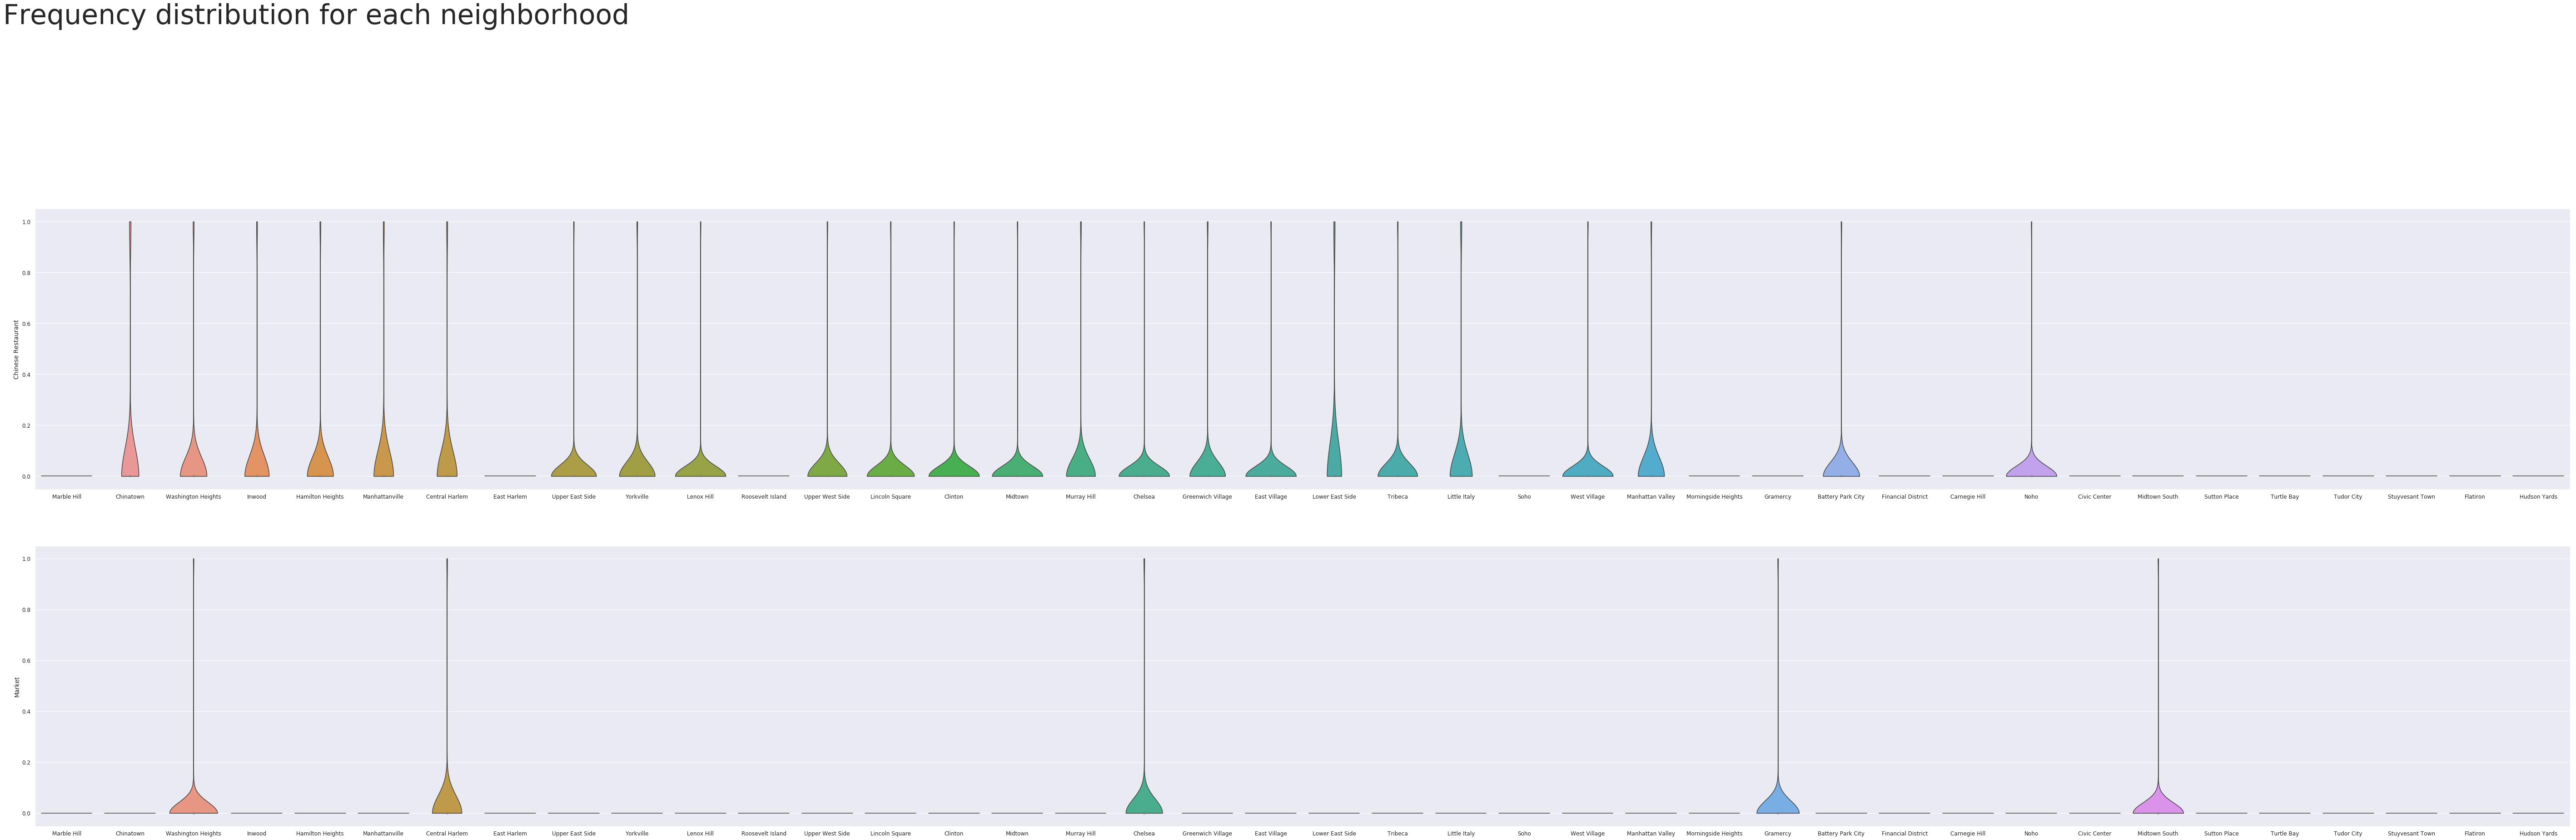

In [36]:
# Categorical plot
# Explore a plot of this data (a violin plot is used which is a density estimation of the underlying distribution).
# The top 3 venue types as specified by the client for each neighborhood are used for the plotting.

import seaborn as sns

fig = plt.figure(figsize=(100,25))
sns.set(font_scale=1.1)

ax = plt.subplot(2,1,1)
sns.violinplot(x="Neighborhood", y="Chinese Restaurant", data=Manhattan_onehot, cut=0);
plt.xlabel("")

ax = plt.subplot(2,1,2)
sns.violinplot(x="Neighborhood", y="Market", data=Manhattan_onehot, cut=0);
plt.xlabel("")

ax.text(-1.0, 3.1, 'Frequency distribution for each neighborhood', fontsize=60)
plt.show()

From the chart above, we can see the 3 good places are
Chinatown,Central Harlem and Chelsea